## Problem Statement ##

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

<img src="climatechange11.jpg" width="350" alt="Drawing" style="width: 350px;"/>

We are task to create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

## Class Description ##

* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

## Importing Packages ##

In [16]:
# Data Analysis and Wrangling
import pandas as pd
import numpy as np

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
import string
import re
import nltk
from nltk.corpus import stopwords
import time
import collections
from collections import Counter

# Modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn.metrics import f1_score
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier

# Model Evaluation Metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

nltk.download(['punkt','stopwords'])
%matplotlib inline
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tlotl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tlotl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing Data ##

In [17]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

## Data Description ##

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The training data has 3 columns in total with 15819 ,with no null values.

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


The testing data has a total of  2 columns  with 10546 entries ,with no null values.

## Preprocessing ##

In [20]:
#changing the column to lower case
train['message'] = train['message'].str.lower()

## Data Cleaning ##

In [21]:

def clean_text(df, text_field):
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|('[0-9]+')|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
test = clean_text(test, "message")
train = clean_text(train, "message")

Yayi we have now removed emails from our data because may can a lot of duplicate values . when removing them it helps to prevent overfitting.

In [22]:
def remove_pun(text):
    for pun in string.punctuation:
        text = text.replace(pun,"")
    return text
train["no_pun"] = train['message'].apply(remove_pun)
test["no_pun"] = test['message'].apply(remove_pun)

Punctuations have been removed from our data . The data cleaning is going good .

In [23]:
def expand_contractions(text):
    text = contractions.fix(text)
    return text
train['cleaned'] = train['no_pun'].apply(lambda x:expand_contractions(x))
test['cleaned'] = test['no_pun'].apply(lambda x:expand_contractions(x))

Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word.The goal is to remove word affixes (particularly suffixes) that modify meaning.

In [24]:
stemm = SnowballStemmer('english')
train['stem'] = train.message.apply(stemm.stem)

Tokenization is the process of tokenizing or splitting a string, text into a list of tokens. One can think of token as parts like a word is a token in a sentence, and a sentence is a token in a paragraph. Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [25]:
from nltk.tokenize import TreebankWordTokenizer
token = TreebankWordTokenizer()

train['token'] = train.stem.apply(token.tokenize)

In [26]:
# We will bring our tokens back together
rejoin = lambda tokens: ' '.join(tokens)
stem = train['token'].apply(rejoin).str.lower()

## Exploratory data analysis ##

In [27]:
train['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

We can see that we are dealing with imbalanced which may be a problem when we are training our model.We also see that the positive sentiment has the highest number of entries.Which we might think that most people in our data believe in climate change ,We need to do more digging to come to a conclusion .

c:\Users\tlotl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


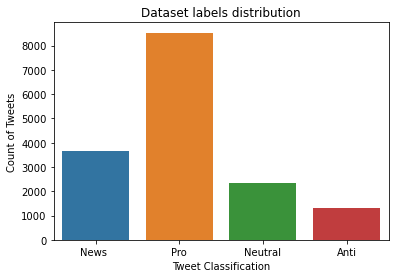

In [28]:
#Create a barplot for the train dataset classes
News = train['sentiment'].value_counts()[2] 
Pro= train['sentiment'].value_counts()[1]   
Neutral=train['sentiment'].value_counts()[0]
Anti=train['sentiment'].value_counts()[-1]  

sns.barplot(['News ','Pro','Neutral','Anti'],[News,Pro,Neutral,Anti]) #Use seaborn barplot and add a list of classes
plt.xlabel('Tweet Classification') #X-label of the data
plt.ylabel('Count of Tweets')      #Y_label of the data
plt.title('Dataset labels distribution') #Give the data a title 'Dataset lables distribution'
plt.show() ##Display the dataset

Taking a closer look at the distribution of the tweets we notice that the data is severely imbalanced with the majority of tweets falling in the 'pro' category, supporting the belief of man-made climate change.

Text(0.5, 0, 'Sentiment Class')

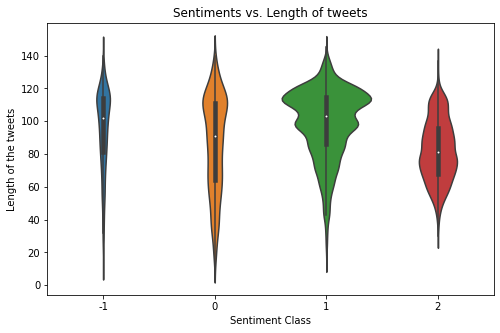

In [29]:
train['message_length'] = train['message'].apply(len)
#Create a violinplot of the dataset
plt.figure(figsize=(8,5)) #Set the figsize to 8 and 5 respectively
plt.title('Sentiments vs. Length of tweets') #Add the title of the violin plot
sns.violinplot(x='sentiment', y='message_length', data=train,scale='count') #Add the dimentions of the violin plot
plt.ylabel("Length of the tweets") #Y_lable of the plot
plt.xlabel("Sentiment Class") #X_label of the plot

From the plots below we can see that tweets that fall in the pro climate change class are generally longer and the shortest tweets belong to the anti climate change class. We also notice that neutral climate change tweets tend to have the most variability in tweet length.

### Word Cloud ###

In [30]:
#Create strings for each class
positive_words =' '.join([text for text in train['stem'][train['sentiment'] == 1]]) #Words in the positve class
negative_words = ' '.join([text for text in train['stem'][train['sentiment'] == -1]]) #Words in negative class
normal_words =' '.join([text for text in train['stem'][train['sentiment'] == 0]]) #Words in the neutral class
news_words =' '.join([text for text in train['stem'][train['sentiment'] == 2]]) #Words in the news class

In [31]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common positive words")
plt.axis('off')

NameError: name 'WordCloud' is not defined

The wordcloud suggests that most positive sentiments are global warming, climate change, believe, real and the likes depicted in the wordcloud.There is no links or http indicating that we did a lot of data cleaning and it worked.With the wordcloud we can see the words complient the positive sentiment.


In [ ]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common Negative words")
plt.axis('off')

A vast majority of the key words in the negative sentiments are very political and scientific, which indicates a lot of sentimens said by world leaders on the topic of climate change. Trump, a firm anti climate change individual is appearing very significantly, including the terms scientist, made, fake, alarmist which shows either a lot of people not believing that is real on a hunch or because of a lack of scientific evidence to support the claims. There also a lot of words like scam, money, man-made going on indicating one of the reasons they may not really believe climate change or have negative sentiment against it.

In [ ]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common Neutral words")
plt.axis('off')

A majority of the neutrals are discussing, engaging and asking about the effects on climate change as seen with words interviewer,scientist . They are speaking about the penguins which are indangered due to the effects of climate change. They speak about the climate change, global warm. 

In [ ]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(news_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common News words")
plt.axis('off')

As we can see that Donald Trump plays a huge role when it comes to the news sentiment. They also report a vast majority of issues all included in the analysis of the other words included.executive order is appearing regularly as well. The word cloud is also indicating that the words are well distributed and spoken of almost similarly. Most of the words are not frequently requiring except 'Climate Change'.

## Feature Extraction ##

CountVectorizer is a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors (for using in further text analysis).

In [ ]:
ngram_range = (4, 4)
min_df = 2
max_df = 0.9 
stem_vectrz = CountVectorizer(analyzer = 'char', ngram_range=ngram_range, min_df=min_df, max_df=max_df)
stem_msg_vec = stem_vectrz.fit_transform(stem)

X_stem = stem_msg_vec

y = train['sentiment']

In [ ]:
print(X_stem.shape)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_stem,y,test_size = 0.01,random_state = 42)

### SVC ##

Support Vector Machines aresimilar to the logistic regression, they fit a linear decision boundary. However, unlike logistic regression, they do this in a non-proabilistic way and are able to fit to non-linear data using an algorithm known as the kernel trick. Furthermore, they can be used for both classification and regression. In sklearn, these are called SVC (Support Vector Classifier) and SVR (Support Vector Regression) respectively.

In [ ]:
model = SVC()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

### LogisticRegression ###

Logistic Regression uses the probability of a data point to belonging to a certain class to classify each datapoint to it's best estimated class

Logistic regression has been rated as the best performing model for linearly separable data especially if it's predicting binary data(Yes & NO or 1 & 0), and performs better when there's no class imbalance. 

The figure below is the sigmoid function logistic regression models use to make predictions:

<img src="LogReg_1.png" width="350" alt="Drawing" style="width: 350px;"/>

In [ ]:
LFC = LogisticRegression()
LFC.fit(X_train,y_train)
y_pred = LFC.predict(X_test)
print(classification_report(y_test, y_pred))

### LinearSVC ###

In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. The goal of the SVM algorithm is to create the best line or decision boundary that can seperate n-dimensional space into classes so that we can easily put the new data point in the correct category in the future. This best decision boundary is called a hyperplane.

SVM chooses the extreme points/vectors that help in creating the hyperplane. These extreme cases are called as support vectors. Consider the below diagram in which there are two different categories that are classified using a decision boundary or hyperplane:

In [ ]:
LSC = LinearSVC(C=0.1, class_weight='balanced',max_iter=1800)
                                    
LSC.fit(X_train,y_train)
y_pred = LSC.predict(X_test)
print(classification_report(y_test, y_pred))

### Random forest classification ###

Random Forest is a tree-based machine learning algorithm that leverages the power of multiple decision trees for making decisions. As the name suggests, it is a “forest” of trees!

The following diagram is a visual representation of the random forest classification method:
<img src="example-of-random-forest-classifier.png" width="350" alt="Drawing" style="width: 350px;"/>

## Model Selection ##

In [ ]:
LFC = LogisticRegression(C=3)
LFC.fit(X_train,y_train)
y_pred = LFC.predict(X_test)
print(classification_report(y_test, y_pred))

LogisticRegression is our best performing model ,but as we see that our model overfitts which can be caused by a lot of things like the imbalance of data.

In [ ]:
model_save_path = "lr_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(LFC,file)

Files saved using pickle are called pickles and the process of making them is referred to as pickling (we know, they took the metaphor quite far...). Luckily for us, saving models using pickle follows a similar structure to that of creating or writing to a file in Python.

## Testing Data ##

In [ ]:
# creating a copy of the test data
test_df = test.copy()

In [ ]:
#stemming our data
test_df['stem'] = test_df.no_pun.apply(stemm.stem)

In [ ]:
# tokenizing our stemmed words
test_df['token'] = test_df.stem.apply(token.tokenize)

In [ ]:
stemmed = test_df['token'].apply(rejoin).str.lower()

In [ ]:
#using CounterVectorizer to extract feature from our cleaned data for modeling
st = stem_vectrz.transform(stemmed)

In [ ]:
# looking at the shape to see if we have the same number of features between our training and testing data
st.shape

### Creating a Submission file ###

In [ ]:
def generate_submission(model, pred_X):
    # prediction
    y_pred = model.predict(pred_X)

    # submission
    submission = {
        "tweetid": test['tweetid'].values,
        "sentiment": y_pred,
    }
    return pd.DataFrame(submission).set_index('tweetid')

In [ ]:
submit_df = generate_submission(LFC, st)
submit_df.to_csv('Anna_LFC.csv')
print("Submission Generated")